In [1]:
import pathpyG as pp

from pathpyG.nn.dbgnn import DBGNN
from torch_geometric.transforms import RandomNodeSplit
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

print('Running on', pp.config['torch']['device'])

Running on cuda


# Load the synthetic dataset

In [2]:
# read the paths
paths = pp.PathData.from_csv('../data/temporal_clusters.ngram')

In [3]:
# Create the graph corresponding to paths
g = pp.HigherOrderGraph(paths, order=1)

# Plotting the time-aggregated network (first-order graph)
# pp.plot(g)

In [4]:
# Create the second-order graph corresponding to paths
g2 = pp.HigherOrderGraph(paths, order=2)

# Plotting the second-order graph
# pp.plot(g2)

# Prepare the data

In [5]:
# Define edge indices for first and second-order graphs
edge_index_g1 = g.data.edge_index
edge_index_g2 = g2.data.edge_index

In [6]:
# Define edge weights
edge_weights = g.data['edge_weight']
edge_weights_higher_order = g2.data['edge_weight']

In [7]:
# Define bipartite mapping
import torch

def generate_bipatite_edge_index(mapping = 'last'):

    if mapping == 'last':
        bipartide_edge_index = torch.tensor([list(g2.node_index_to_id.keys()),
                                     [i[1] for i in g2.node_index_to_id.values()]])

    elif mapping == 'first':
        bipartide_edge_index = torch.tensor([list(g2.node_index_to_id.keys()),
                                     [i[0] for i in g2.node_index_to_id.values()]])

    else:
        bipartide_edge_index = torch.tensor([list(g2.node_index_to_id.keys()) + list(g2.node_index_to_id.keys()),
                                     [i[0] for i in g2.node_index_to_id.values()] + [i[1] for i in g2.node_index_to_id.values()]])

    return bipartide_edge_index


# Original DBGNN implementation mapping = 'last'
bipatite_edge_index = generate_bipatite_edge_index(mapping='last')

In [8]:
# Define the PyG data object
from torch_geometric.data import Data

num_nodes = max(max(g.data['edge_index'][0]), max(g.data['edge_index'][1])).item() + 1 # since indexing starts from 0
num_ho_nodes = max(max(g2.data['edge_index'][0]), max(g2.data['edge_index'][1])).item() + 1 # since indexing starts from 0

data = Data(
    num_nodes = num_nodes,
    num_ho_nodes = num_ho_nodes,
    x = torch.eye(num_nodes, num_nodes),
    x_h = torch.eye(num_ho_nodes, num_ho_nodes),
    edge_index = edge_index_g1,
    edge_index_higher_order = edge_index_g2,
    edge_weights = edge_weights.float(),
    edge_weights_higher_order = edge_weights_higher_order.float(),
    bipartite_edge_index = bipatite_edge_index,
    y = torch.tensor([ int(i) // 10 for i in paths.node_id])
)

# DBGNN 

In [9]:
device = 'cuda' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
from sklearn.metrics import balanced_accuracy_score

def test(model, data):
    model.eval()

    _, pred = model(data).max(dim=1)

    metrics_train = balanced_accuracy_score(
        data.y[data.train_mask].cpu(),
        pred[data.train_mask].cpu().numpy()
        )

    metrics_test = balanced_accuracy_score(
        data.y[data.test_mask].cpu(),
        pred[data.test_mask].cpu().numpy()
        )

    return metrics_train, metrics_test

In [11]:

RandomNodeSplit(num_val=0, num_test=0.3)(data)

model = DBGNN(
        num_features =[num_nodes, num_ho_nodes],
        num_classes = len(data.y.unique()),
        hidden_dims = [16, 32, 8],
        p_dropout = 0.4
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(),  lr=0.005)
loss_function = torch.nn.CrossEntropyLoss()

data = data.to(device)

In [12]:
print(model)

DBGNN(
  (higher_order_layers): ModuleList(
    (0): GCNConv(560, 16)
    (1): GCNConv(16, 32)
  )
  (first_order_layers): ModuleList(
    (0): GCNConv(30, 16)
    (1): GCNConv(16, 32)
  )
  (bipartite_layer): BipartiteGraphOperator()
  (lin): Linear(in_features=8, out_features=3, bias=True)
)


In [13]:
losses = []
for epoch in tqdm(range(1000)):
        output = model(data)
        loss = loss_function(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)

        if epoch % 10 == 0:
                train_ba, test_ba  = test(model, data)
                print(f'Epoch: {epoch}, Loss: {loss}, Train balanced accuracy: {train_ba}, Test balanced accuracy: {test_ba}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.2165470123291016, Train balanced accuracy: 0.3333333333333333, Test balanced accuracy: 0.3333333333333333
Epoch: 10, Loss: 0.5921721458435059, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 20, Loss: 0.06649573147296906, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 30, Loss: 0.004955393727868795, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 40, Loss: 0.0008131247013807297, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 50, Loss: 0.00029230682412162423, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 60, Loss: 0.00017307818052358925, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 70, Loss: 0.0001321418531006202, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 80, Loss: 0.00011313641152810305, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 90, Loss: 0.00010172936163144186, Train balanced accuracy: 1.0, Test balanced accuracy: 

# Latent space representation of edges

In [14]:
g2.node_index_to_id[0]

(0, 1)

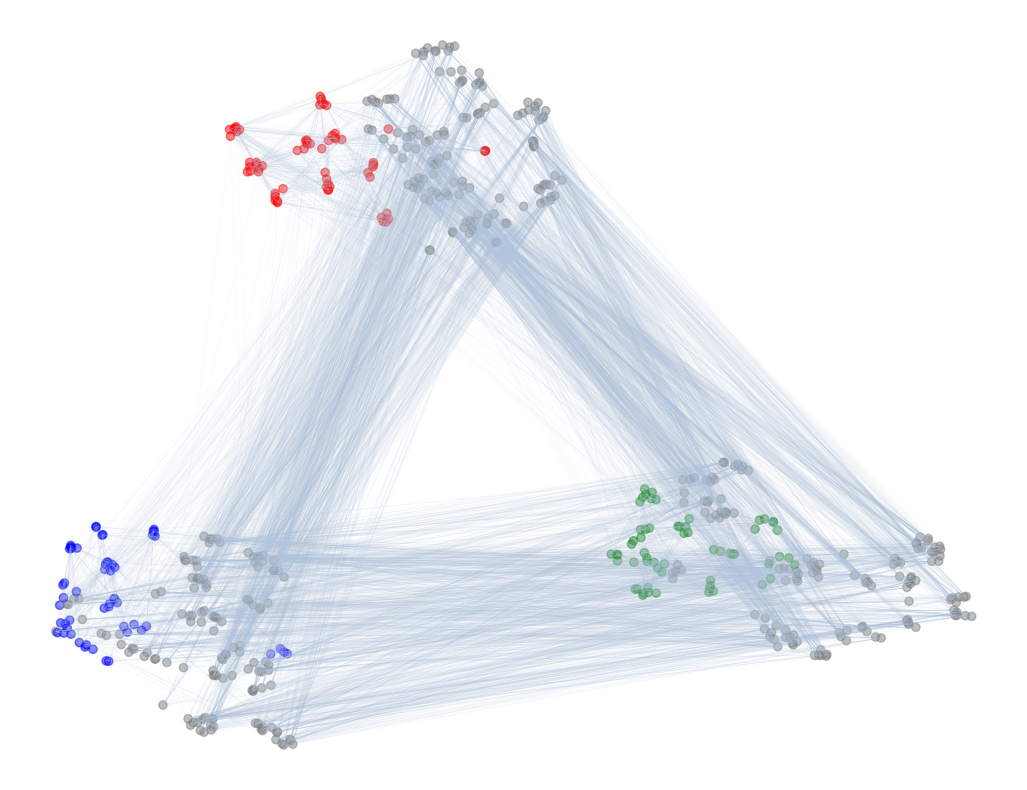

In [15]:
model.eval()
latent = model.higher_order_layers[0].forward(data.x_h, data.edge_index_higher_order).detach()
node_embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent.cpu())

colors = []
for v, w in g2.nodes:
    if data.y[v] == 0 and data.y[w] == 0:
        colors.append('red')
    elif data.y[v] == 1 and data.y[w] == 1:
        colors.append('green')
    elif data.y[v] == 2 and data.y[w] == 2:
        colors.append('blue')
    else:
        colors.append('grey')

plt.figure(figsize=(13,10))
plt.scatter(node_embedding[:,0], node_embedding[:,1], c=colors, alpha=0.5)

for e in g2.edges:
    s = g2.node_id_to_index[e[0]]
    t = g2.node_id_to_index[e[1]]
    plt.plot([node_embedding[s,0], node_embedding[t,0]], [node_embedding[s,1], node_embedding[t,1]], 
             color='lightsteelblue', 
             linestyle='-', 
             alpha=0.2,
             lw=0.2)
plt.axis('off')
plt.show()

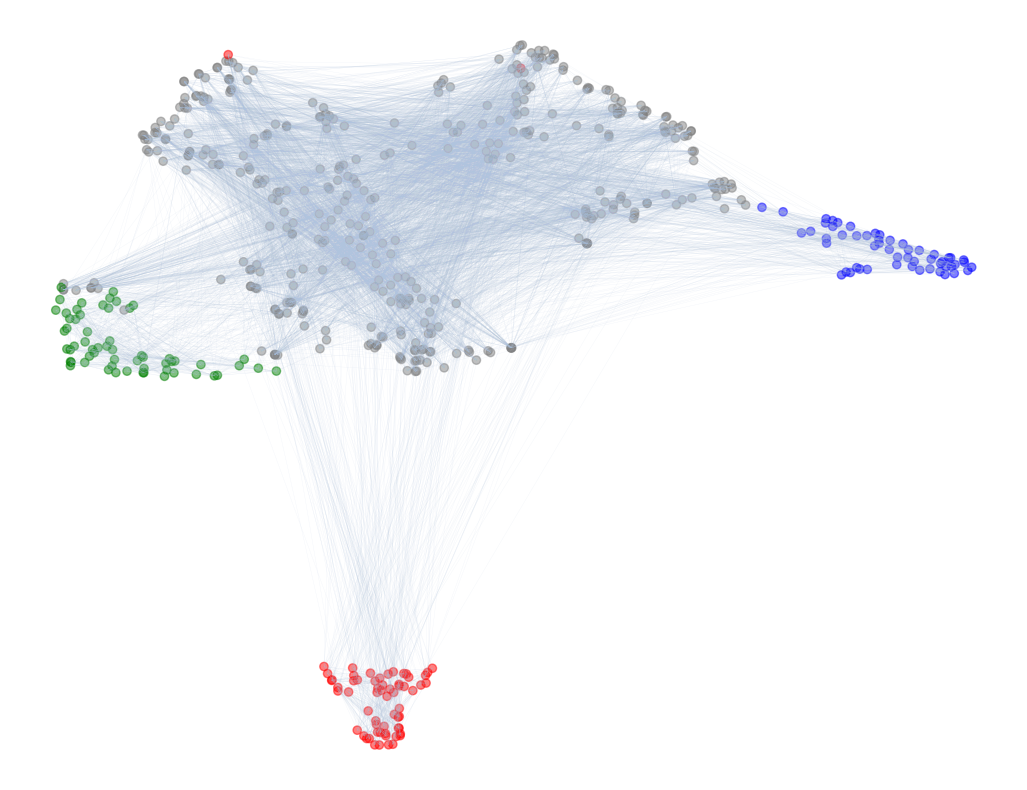

In [16]:
model.eval()
latent = model.higher_order_layers[1].forward(latent.cuda(), data.edge_index_higher_order).detach()
node_embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent.cpu())

colors = []
for v, w in g2.nodes:
    if data.y[v] == 0 and data.y[w] == 0:
        colors.append('red')
    elif data.y[v] == 1 and data.y[w] == 1:
        colors.append('green')
    elif data.y[v] == 2 and data.y[w] == 2:
        colors.append('blue')
    else:
        colors.append('grey')

plt.figure(figsize=(13,10))
plt.scatter(node_embedding[:,0], node_embedding[:,1], c=colors, alpha=0.5)

for e in g2.edges:
    s = g2.node_id_to_index[e[0]]
    t = g2.node_id_to_index[e[1]]
    plt.plot([node_embedding[s,0], node_embedding[t,0]], [node_embedding[s,1], node_embedding[t,1]], 
             color='lightsteelblue', 
             linestyle='-', 
             alpha=0.2,
             lw=0.2)
plt.axis('off')
plt.show()

# Latent space representation of nodes

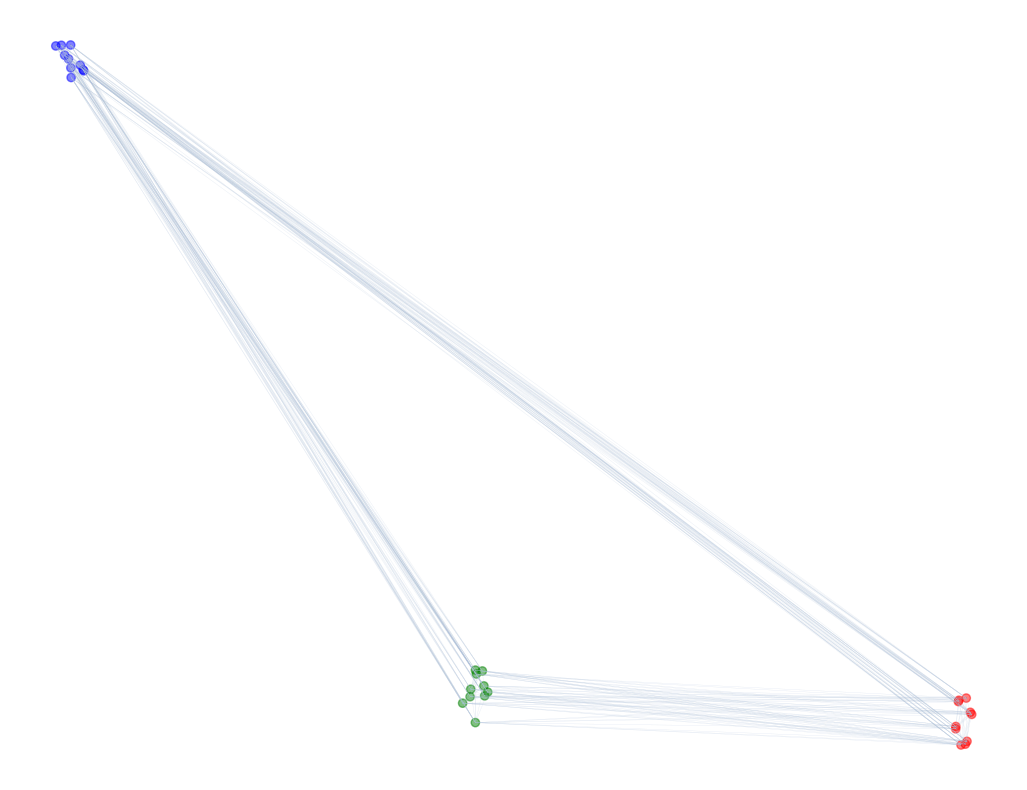

In [22]:
model.eval()
latent = model.forward(data).detach()
node_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(latent.cpu())

colors = []
for v in g.nodes:
    if data.y[v] == 0:
        colors.append('red')
    elif data.y[v] == 1:
        colors.append('green')
    elif data.y[v] == 2:
        colors.append('blue')
    else:
        colors.append('grey')

plt.figure(figsize=(13,10))
plt.scatter(node_embedding[:,0], node_embedding[:,1], c=colors, alpha=0.5)

for e in g.edges:
    s = e[0]
    t = e[1]
    plt.plot([node_embedding[s,0], node_embedding[t,0]], [node_embedding[s,1], node_embedding[t,1]], 
             color='lightsteelblue', 
             linestyle='-', 
             alpha=0.2,
             lw=0.2)
plt.axis('off')
plt.show()